In [1]:
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
model = torch.load("./trained_model")
model.eval()

# PIL image -> tensor
loader = transforms.Compose([transforms.ToTensor()])
# tensor -> PIL image
unloader = transforms.ToPILImage()
preprocess = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


In [2]:
class PredictSegDataset(Dataset):
    def __init__(self, img_dir, img_transform = None):
        self.img_dir = img_dir
        self.n_img = 2
        self.img_transform = img_transform

    def __len__(self):     
        return self.n_img

    def __getitem__(self, idx):  
        img = Image.open(self.img_dir).convert("RGB")
        if self.img_transform:
            img = self.img_transform(img)      
        return img

batch_size = 2
img_path = "./images/test/original.jpg"
predict_set = PredictSegDataset(img_path, preprocess)
generator = DataLoader(predict_set, batch_size=batch_size, shuffle=False)

In [3]:
for img in iter(generator):
        model.eval()
        img = img.to(device).to(torch.float32)
        output = model(img)['out']
        break

output = output[0].cpu()

C:\Users\z1061\Anaconda3\envs\pytorchenv_gpu\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [4]:
output[output>0.1] = 1
output[output<0.1] = 0
prediction = unloader(output)
prediction.save(f"./images/test/prediction.jpg")

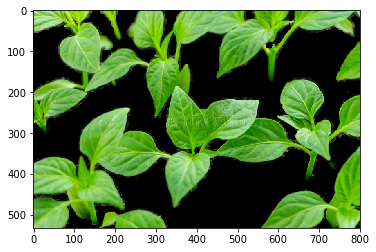

In [5]:
flag = np.asarray(prediction)
original = Image.open(img_path).convert("RGB")
arr = np.asarray(original)
for i in range(flag.shape[0]):
    for j in range(flag.shape[1]):
        if flag[i,j]==0:
            arr[i,j] = [0, 0, 0]
            
plt.imshow(arr)

In [6]:
pil_image=Image.fromarray(arr)
pil_image.save("./images/test/masked.jpg")